# Verification of tidal waveforms

Here we show the (mis)matches we obtained with our tidal waveforms code to check the implementation. Idea is to run the Python script under test, which saves the samples with parameters and match values to a CSV, and then load it and analyze it here.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

# from ripple.waveforms import IMRPhenomD
import matplotlib.pyplot as plt
from ripple import ms_to_Mc_eta
from ripple.constants import MSUN, gt
from jax import grad, vmap
from functools import partial
# import importlib
# import tqdm

%load_ext autoreload
%autoreload 2

params = {"axes.grid": True,
          "text.usetex" : True,
          "font.family" : "serif",
          "ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "font.serif" : ["Computer Modern Serif"],
          "xtick.labelsize": 16,
          "ytick.labelsize": 16,
          "axes.labelsize": 16,
          "legend.fontsize": 16,
          "legend.title_fontsize": 16,
          "figure.titlesize": 16}

plt.rcParams.update(params)


jax.config.update("jax_enable_x64", True) # improve precision for comparing waveforms

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import pandas as pd
os.getcwd()

'/Users/Woute029/Documents/Code/ripple/notebooks'

In [3]:
def get_chi_eff(chi1, chi2, m1, m2):
    return (chi1 * m1 + chi2 * m2) / (m1 + m2)

def get_chirp_mass(m1, m2):
    return (m1 * m2)**(3/5) / (m1 + m2)**(1/5)

## Load in match files

In [4]:
# Choose tidal waveform here
IMRphenom = "IMRPhenomD_NRTidalv2"
matches_filename = os.path.join(os.getcwd(), f"../test/matches_data/check_{IMRphenom}_matches.csv")
print(f"Reading in matches from {matches_filename}")
matches_df = pd.read_csv(matches_filename)

### Get the values
m1_values = matches_df["m1"].values
m2_values = matches_df["m2"].values
q_values = matches_df["m2"] / matches_df["m1"].values
chi1_values = matches_df["chi1"].values
chi2_values = matches_df["chi2"].values
lambda1_values = matches_df["lambda1"].values
lambda2_values = matches_df["lambda2"].values
match_values = matches_df["match"].values
mismatch_values = matches_df["mismatch"].values

### Show the df
matches_df

Reading in matches from /Users/Woute029/Documents/Code/ripple/notebooks/../test/matches_data/check_IMRPhenomD_NRTidalv2_matches.csv


,Unnamed: 0,m1,m2,chi1,chi2,lambda1,lambda2,dist_mpc,tc,phi_ref,inclination,match,mismatch
0,724,2.908970,2.808420,-0.461653,0.974613,1894.181788,2531.175244,440.0,0.0,0.0,0.0,0.977151,-1.641133
1,463,2.010698,1.680252,0.079404,-0.930094,2419.241539,4365.851437,440.0,0.0,0.0,0.0,0.984227,-1.802075
2,391,2.716501,2.567620,-0.274754,0.846951,323.731069,3015.330925,440.0,0.0,0.0,0.0,0.985385,-1.835210
3,72,2.678704,2.047403,-0.010564,0.908966,4540.203888,853.070450,440.0,0.0,0.0,0.0,0.986484,-1.869163
4,567,2.716105,2.713241,0.324710,0.873466,307.652594,3072.169121,440.0,0.0,0.0,0.0,0.986593,-1.872663
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,88,2.930220,0.876422,0.528797,0.538601,654.780442,1108.837307,440.0,0.0,0.0,0.0,1.000000,-8.965880
996,358,2.331276,2.138961,-0.277880,-0.277576,3431.316084,2129.690362,440.0,0.0,0.0,0.0,1.000000,-9.009567
997,33,2.986236,0.622333,-0.511992,0.512278,4908.168894,257.992564,440.0,0.0,0.0,0.0,1.000000,-9.057999
998,851,2.251822,0.791817,-0.238713,-0.204399,2631.188576,674.022793,440.0,0.0,0.0,0.0,1.000000,-9.133976


In [5]:
chi2_values

array([ 9.74613202e-01, -9.30094044e-01,  8.46951237e-01,  9.08965650e-01,
        8.73465821e-01, -9.98833330e-01, -9.98693076e-01,  9.68376260e-01,
        8.30777445e-01,  9.84660947e-01,  9.80525482e-01,  9.39051206e-01,
       -8.55137616e-01,  9.02590868e-01, -9.76654820e-01, -8.90839298e-01,
       -9.21239814e-01, -9.12288520e-01, -8.43272436e-01, -8.45024974e-01,
       -9.49964482e-01, -9.12349390e-01, -9.91242219e-01, -9.81623525e-01,
        8.59958167e-01,  9.46312000e-01, -9.70875890e-01,  8.29773543e-01,
        5.05471669e-01,  9.68806699e-01,  5.26183603e-01, -4.64361126e-01,
       -9.27137647e-01,  9.60880285e-01, -9.24940343e-01,  8.94027427e-01,
       -3.00554026e-01, -5.59066351e-01,  4.85044866e-01,  9.93479678e-01,
       -9.63601097e-01, -2.56678429e-01, -9.77218009e-01, -9.41139610e-01,
       -3.03455483e-01, -9.53879140e-01,  3.78408790e-01,  3.51705180e-01,
       -3.59647658e-01, -8.06034886e-01,  9.79396042e-01, -8.29258764e-01,
       -2.03931480e-01,  

## Look at match values

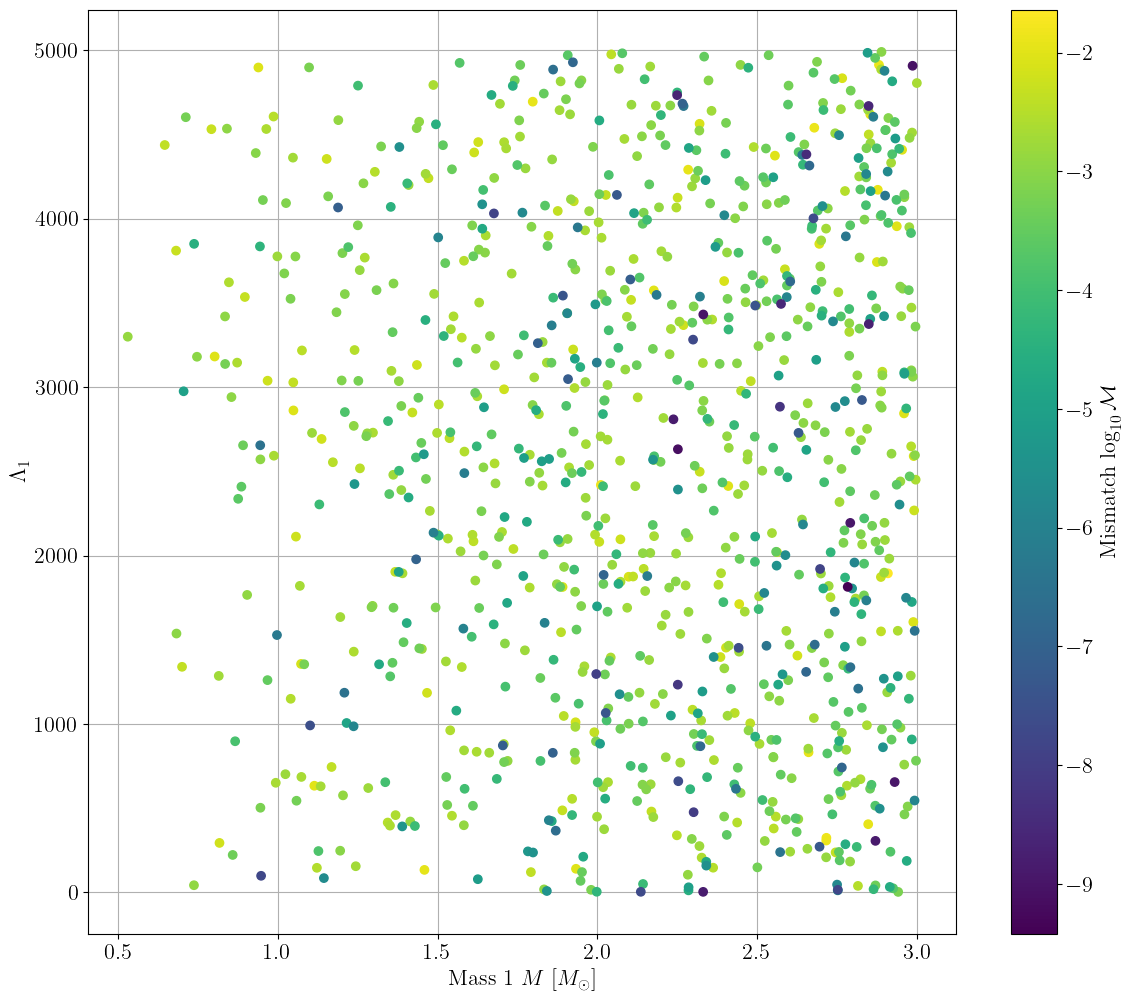

In [6]:
# Plot them
plt.figure(figsize = (14, 12))
plt.scatter(m1_values, lambda1_values, c = mismatch_values, zorder=100)
plt.xlabel(r"Mass 1 $M$ [$M_{\odot}$]")
plt.ylabel(r"$\Lambda_1$")
# plt.title(r"Unequal mass, non-spinning")
cbar = plt.colorbar()
cbar.set_label(r"Mismatch $\log_{10} \mathcal{M}$")
# plt.savefig("../test/figures/matches_NRTidal.pdf", bbox_inches = 'tight')
# plt.savefig("../test/figures/matches_NRTidal.png", bbox_inches = 'tight')
plt.show()

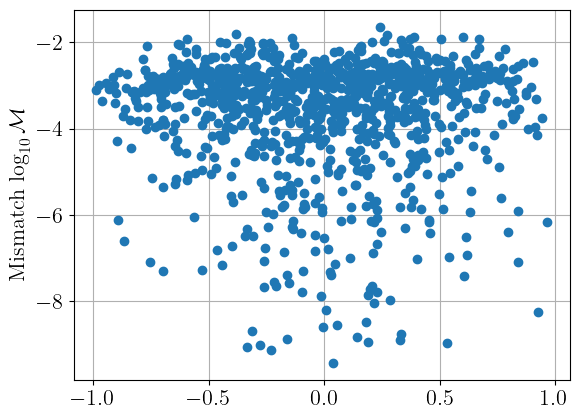

In [7]:
chi_eff = get_chi_eff(chi1_values, chi2_values, m1_values, m2_values)
plt.scatter(chi_eff, mismatch_values, zorder=100)
# plt.xlabel(r"q")
plt.ylabel(r"Mismatch $\log_{10} \mathcal{M}$")
# plt.title(r"Unequal mass, non-spinning")
# plt.savefig("../test/figures/matches_NRTidal_M_vs_mismatch.png", bbox_inches = 'tight')
plt.show()

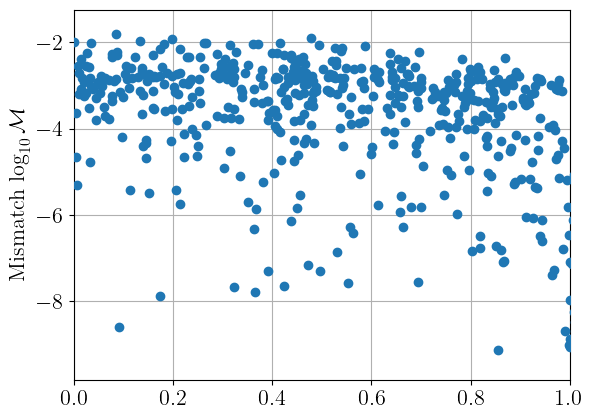

In [8]:
# Define chi_ratios, which is chi1 / chi2 but makes sure that chi1 > chi2
chi_ratios = np.zeros(len(chi1_values))
for i in range(len(chi1_values)):
    if chi1_values[i] >= chi2_values[i]:
        chi_ratios[i] = chi1_values[i] / chi2_values[i]
    else:
        chi_ratios[i] = chi2_values[i] / chi1_values[i]
plt.scatter(abs(chi_ratios), mismatch_values, zorder=100)
# plt.xlabel(r"q")
plt.ylabel(r"Mismatch $\log_{10} \mathcal{M}$")
plt.xlim(0, 1)
# plt.title(r"Unequal mass, non-spinning")
# plt.savefig("../test/figures/matches_NRTidal_M_vs_mismatch.png", bbox_inches = 'tight')
plt.show()

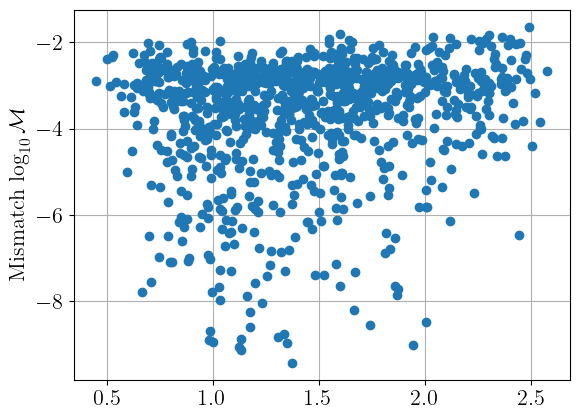

In [9]:
chirp_mass = get_chirp_mass(m1_values, m2_values)
plt.scatter(chirp_mass, mismatch_values, zorder=100)
# plt.xlabel(r"q")
plt.ylabel(r"Mismatch $\log_{10} \mathcal{M}$")
# plt.title(r"Unequal mass, non-spinning")
# plt.savefig("../test/figures/matches_NRTidal_M_vs_mismatch.png", bbox_inches = 'tight')
plt.show()

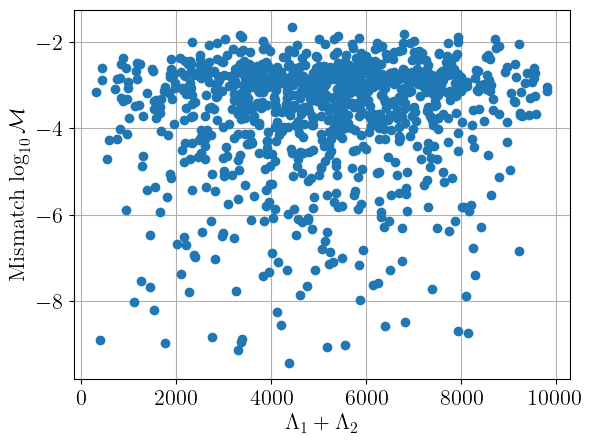

In [10]:
plt.scatter(lambda1_values + lambda2_values, mismatch_values, zorder=100)
plt.xlabel(r"$\Lambda_1 + \Lambda_2$")
plt.ylabel(r"Mismatch $\log_{10} \mathcal{M}$")
plt.show()

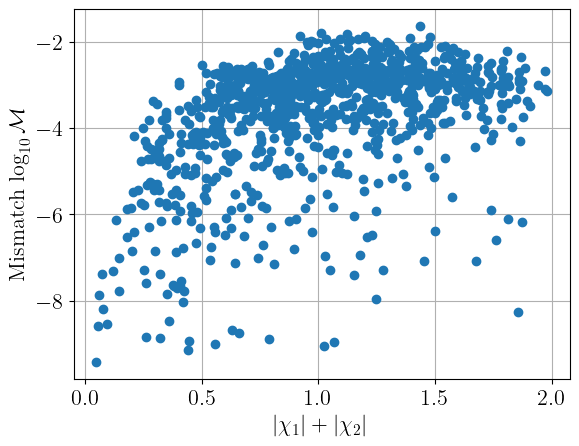

In [11]:
plt.scatter(abs(chi1_values) + abs(chi2_values), mismatch_values, zorder=100)
plt.xlabel(r"$|\chi_1| + |\chi_2|$")
plt.ylabel(r"Mismatch $\log_{10} \mathcal{M}$")
plt.show()

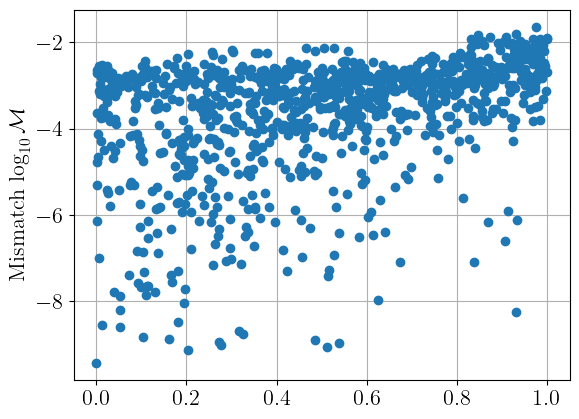

In [12]:
plt.scatter(abs(chi2_values), mismatch_values, zorder=100)
# plt.xlabel(r"$|\chi_1| + |\chi_2|$")
plt.ylabel(r"Mismatch $\log_{10} \mathcal{M}$")
plt.show()

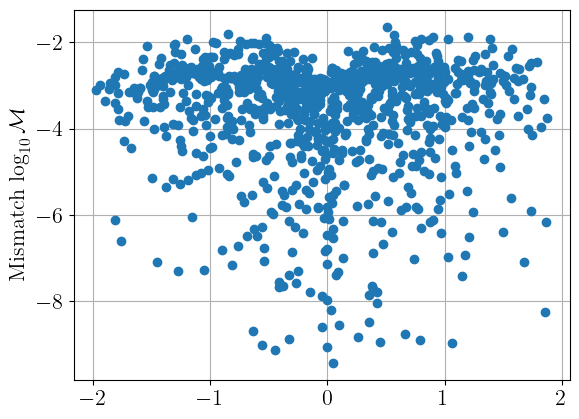

In [13]:
plt.scatter(chi1_values + chi2_values, mismatch_values, zorder=100)
# plt.xlabel(r"q")
plt.ylabel(r"Mismatch $\log_{10} \mathcal{M}$")
# plt.title(r"Unequal mass, non-spinning")
# plt.savefig("../test/figures/matches_NRTidal_M_vs_mismatch.png", bbox_inches = 'tight')
plt.show()

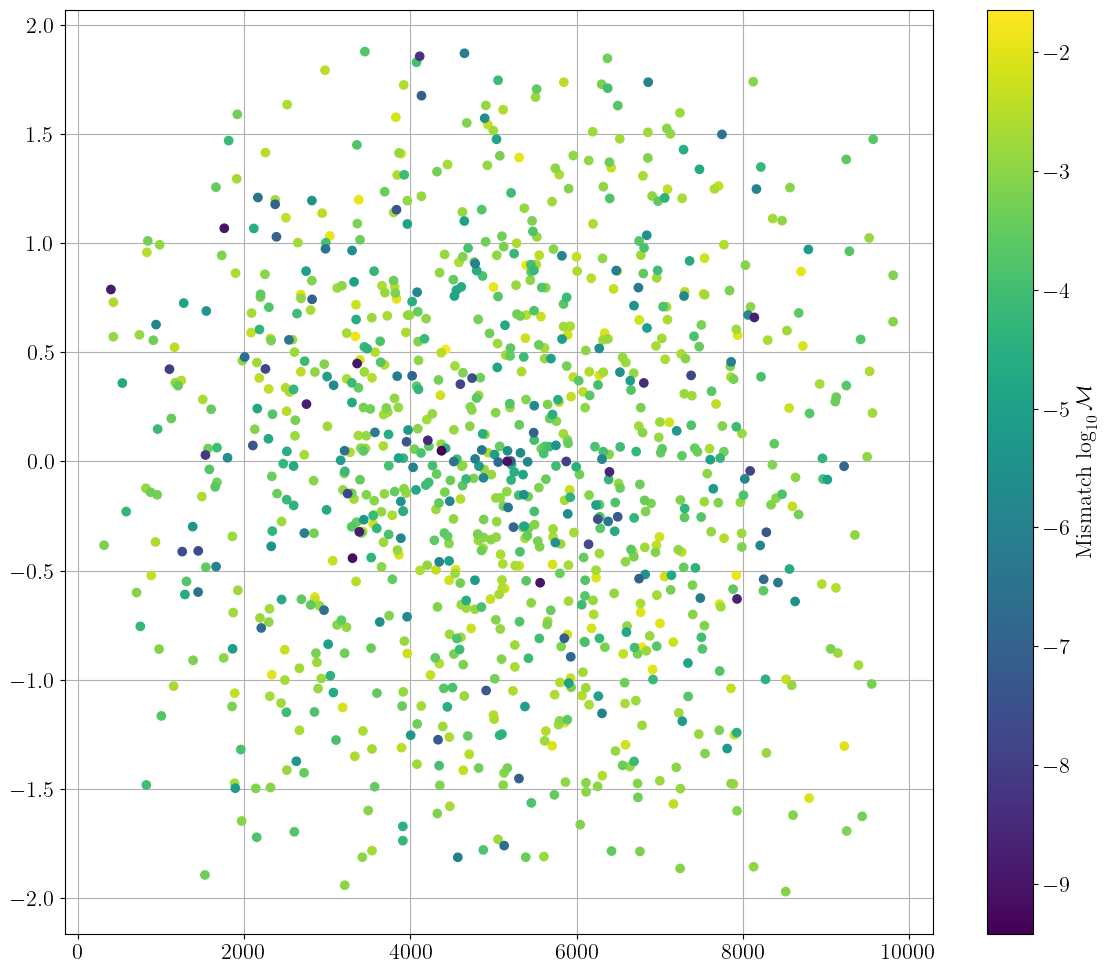

In [14]:
# Plot them
plt.figure(figsize = (14, 12))
plt.scatter(lambda1_values + lambda2_values, chi1_values + chi2_values, c = mismatch_values, zorder=100)
# plt.xlabel(r"$\Lambda_1$")
# plt.ylabel(r"$\Lambda_2$")
cbar = plt.colorbar()
cbar.set_label(r"Mismatch $\log_{10} \mathcal{M}$")
# plt.savefig("../test/figures/matches_NRTidal_lambda1_lambda2.pdf", bbox_inches = 'tight')
# plt.savefig("../test/figures/matches_NRTidal_lambda1_lambda2.png", bbox_inches = 'tight')
plt.show()

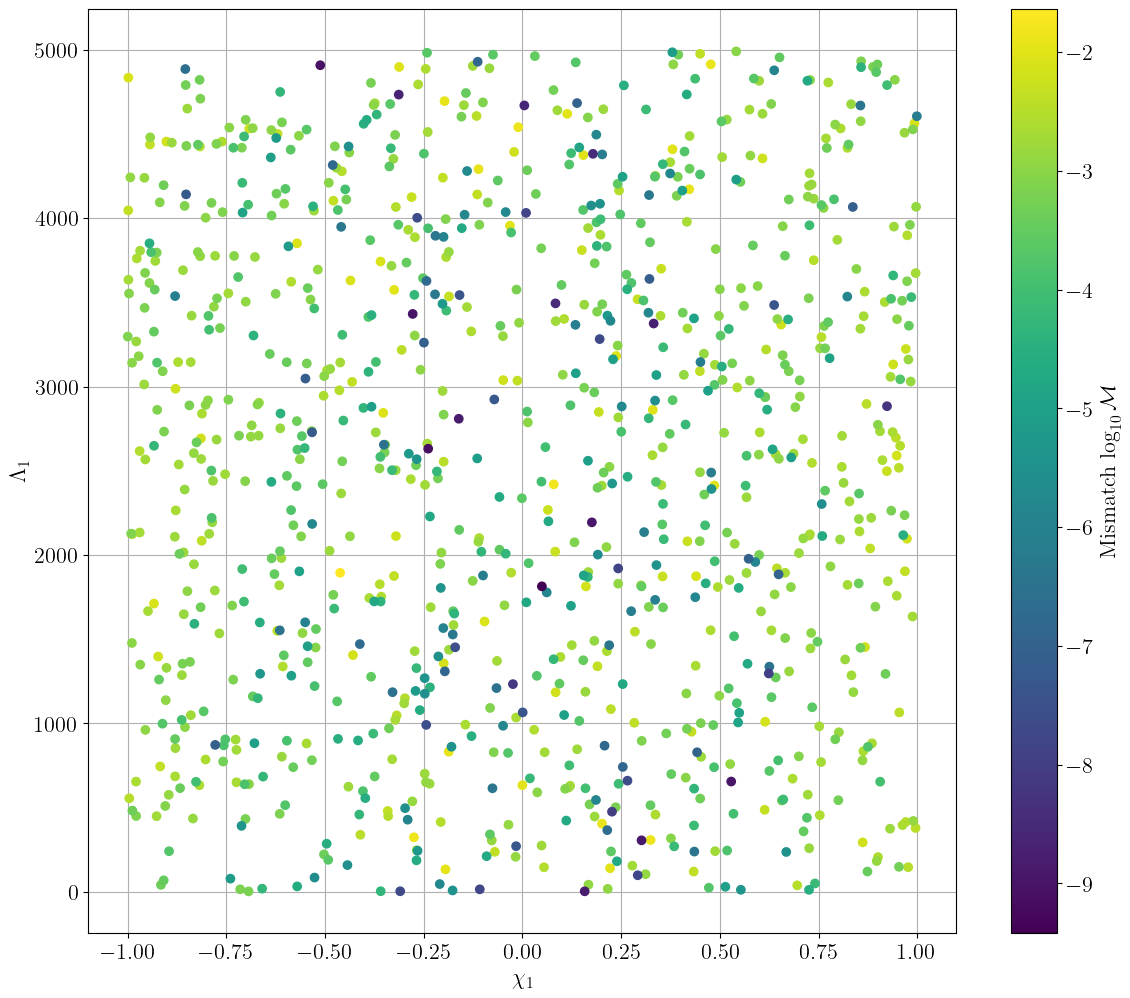

In [15]:
# Plot them
plt.figure(figsize = (14, 12))
plt.scatter(chi1_values, lambda1_values, c = mismatch_values, zorder=100)
plt.xlabel(r"$\chi_1$")
plt.ylabel(r"$\Lambda_1$")
cbar = plt.colorbar()
cbar.set_label(r"Mismatch $\log_{10} \mathcal{M}$")
# plt.savefig("../test/figures/matches_NRTidal_lambda1_lambda2.pdf", bbox_inches = 'tight')
# plt.savefig("../test/figures/matches_NRTidal_lambda1_lambda2.png", bbox_inches = 'tight')
plt.show()

## Check distributions of mismatches

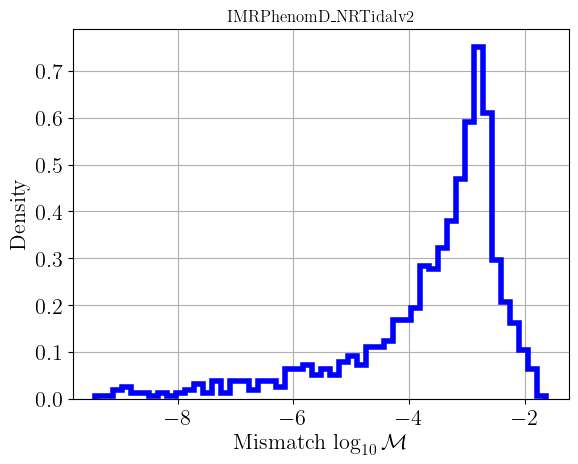

In [16]:
plt.hist(mismatch_values, color="blue", bins=50, histtype='step', linewidth=4, density=True)
plt.xlabel(r"Mismatch $\log_{10} \mathcal{M}$")
plt.ylabel("Density")
plt.title(IMRphenom)
plt.savefig(f"../test/figures/histogram_mismatches_{IMRphenom}.png", bbox_inches = 'tight')
plt.savefig(f"../test/figures/histogram_mismatches_{IMRphenom}.pdf", bbox_inches = 'tight')
plt.show()

Look at the worst sample:

In [17]:
min_match_row = matches_df[matches_df['match'] == matches_df['match'].min()]
min_match_row

,Unnamed: 0,m1,m2,chi1,chi2,lambda1,lambda2,dist_mpc,tc,phi_ref,inclination,match,mismatch
0,724,2.90897,2.80842,-0.461653,0.974613,1894.181788,2531.175244,440.0,0.0,0.0,0.0,0.977151,-1.641133


Look at lambda vs chi mismatch

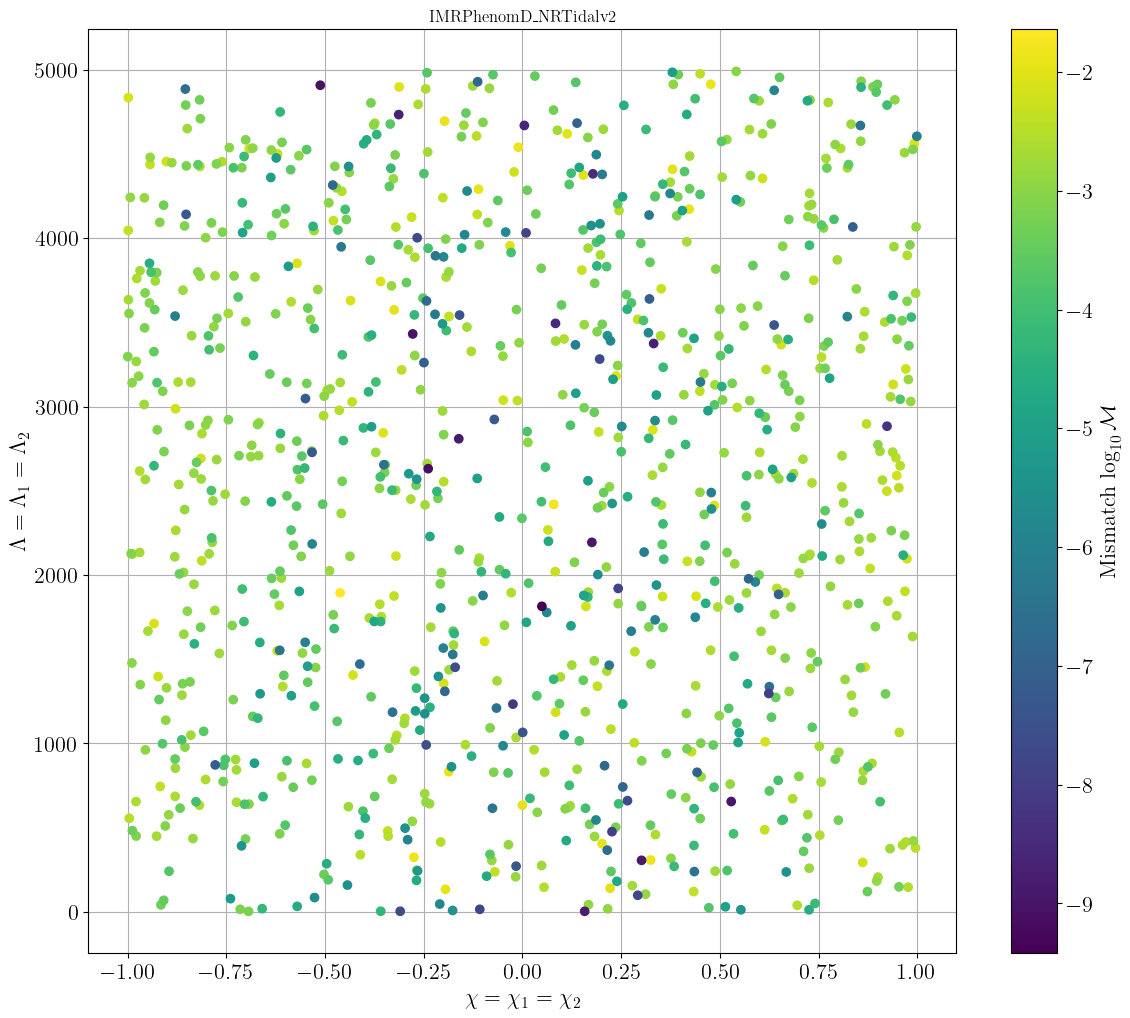

In [18]:
# Plot them
plt.figure(figsize = (14, 12))
plt.scatter(chi1_values, lambda1_values, c = mismatch_values, zorder=100)
plt.xlabel(r"$\chi = \chi_1 = \chi_2$")
plt.ylabel(r"$\Lambda = \Lambda_1 = \Lambda_2$")
cbar = plt.colorbar()
cbar.set_label(r"Mismatch $\log_{10} \mathcal{M}$")
# plt.savefig("../test/figures/matches_NRTidal_lambda1_lambda2.pdf", bbox_inches = 'tight')
# plt.savefig("../test/figures/matches_NRTidal_lambda1_lambda2.png", bbox_inches = 'tight')
plt.title(IMRphenom)
plt.show()